In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec
from step_response import LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "./re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


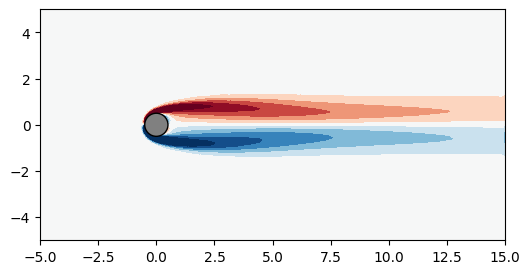

In [2]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


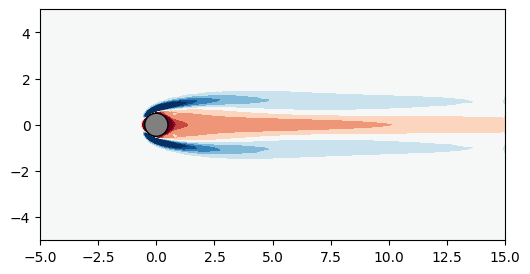

In [3]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

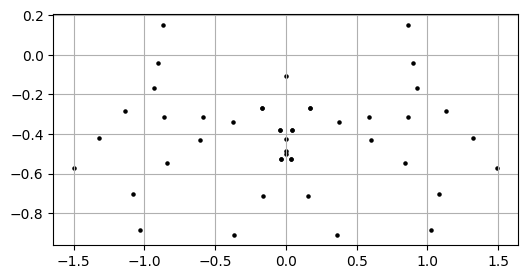

In [4]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

In [5]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

### Natural flow (no actuation)

In [6]:
data_no_act = np.load("re100_open_loop_output/no_actuation.npz")
t = data_no_act['t']
u = data_no_act['u'][:, None]
xc = data_no_act['x']
y = data_no_act['y'][:, None]

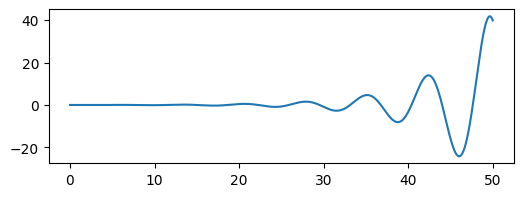

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, y)
plt.show()

### Projection onto global modes

In [8]:
# 4. Projection onto global modes

# r = 9  # Number of global modes for projection
r = len(evals)
print(f"{r=}")
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    # Br[i, 0] = flow.inner_product(qC, W[i])
    Br[i, 0] = flow.inner_product(W[i], qC)
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

r=46


/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


In [9]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # Transformation matrix such that z = T @ x
    T = np.zeros((n, n), dtype=np.cdouble)
    T[di, di] = 1.0
    T[stack_ind + (j, j)] = 0.5j
    T[stack_ind + (j, k)] = 0.5
    T[stack_ind + (k, j)] = -0.5j
    T[stack_ind + (k, k)] = 0.5

    T = T.conj()

    # FIXME: These transformations have weird negative
    # conjugates and negative signs... kind of suggests
    # something is not right here.

    # Transform the measurement matrix
    Cr = np.real(C @ T)

    # Transform the input matrix
    Br = np.real(linalg.inv(T) @ B)

    Dr = D.real

    return Ar, Br, Cr, Dr, T


A_hat, B_hat, C_hat, D_hat, T = real_form(Ar.conj(), Br.conj(), Cr.conj(), Dr)
T_inv = linalg.inv(T)

In [10]:
# q0 = fd.Function(flow.mixed_space).assign(0.5 * (V[0] + V[1]))
q0 = fd.Function(flow.mixed_space).assign(0.5j * (V[0] - V[1]))
flow.q.assign(q0)
print(flow.get_observations())
z0 = np.array([flow.inner_product(q0, W[j]) for j in range(r)])
x0 = np.real(T_inv @ z0)
C_hat @ x0

((-0.010504028045981677+0j), (1.6733791403307258e-07+0j))


array([-0.01050403])

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [11]:
data_no_act = np.load("re100_open_loop_output/no_actuation.npz")
t = data_no_act['t']
dt = t[1] - t[0]
u = data_no_act['u'][:, None]
xc = data_no_act['x']
x = xc @ T_inv.T
y = data_no_act['y'][:, None]

In [12]:
x.real.max(), x.imag.max()

(3351.5888355228317, 2.2872139748830733e-07)

In [13]:
# kf_sys = control.ss(A_hat, np.hstack((B_hat, L)), C_hat, np.hstack((D_hat, [0.0])))
# np.hstack((B_hat, L)).shape

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

p = 1  # Number of measurements
m = 1  # Number of inputs

In [14]:
# Kalman filter

Qf = np.eye(r)
Rf = 1e8 * np.eye(p)
L, _, E = control.dlqr(A_kf.T, C_kf.T, Qf, Rf)
L = L.T
# print(L)
# print(np.log(E) / dt)

### No control

In [15]:
n_steps = len(t)

z = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

for i in range(n_steps):

    # Update the Kalman filter estimate 
    if i > 0:
        y_hat[i] = np.real(C_kf @ z[i-1])
        z[i] = A_kf @ z[i-1] + L @ (y[i] - y_hat[i])

    else:
        z[i] = x[i]


/tmp/ipykernel_76882/1231287016.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  z[i] = x[i]


In [16]:
x_rom = np.zeros_like(x)
x_rom[0] = x[0]

for i in range(1, n_steps):
    x_rom[i] = A_kf @ x_rom[i-1]

/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/firedrake/firedrake/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


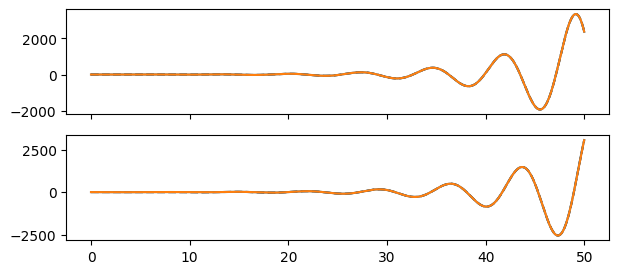

In [17]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(t, x[:, 0], 'k--')
ax[0].plot(t, z[:, 0])
ax[0].plot(t, x_rom[:, 0].real)
ax[1].plot(t, x[:, 1], 'k--')
ax[1].plot(t, z[:, 1])
ax[1].plot(t, x_rom[:, 1].real)
plt.show()

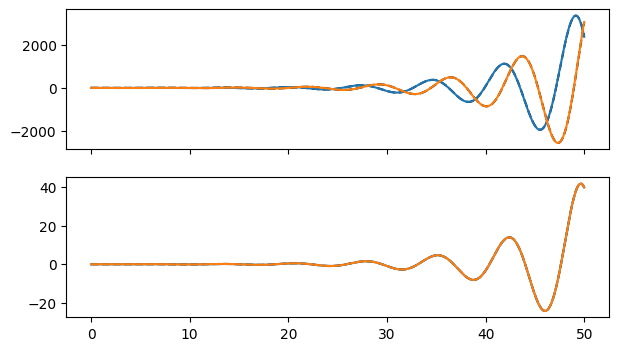

In [18]:

# Transform the measurement matrix

fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, :2]), 'k--')
ax[0].plot(t, np.real(z[:, :2]))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[1].plot(t, x @ C_kf.T)
plt.show()

### Kalman filter with forcing

For simplicity, run this with the explicit forcing control (instead of BC control).  This fails, showing that the global modes are not sufficient to construct a model that will capture the input/output behavior

In [19]:
data = np.load("re100_open_loop_output/sine_actuation_ex.npz")
t = data['t']
u = data['u'][:, None]
xc = data['x']
x = xc @ T_inv.T
y = data['y'][:, None]
rho = data['rho']

In [23]:
L[:2]

array([[0.50992466],
       [0.14098906]])

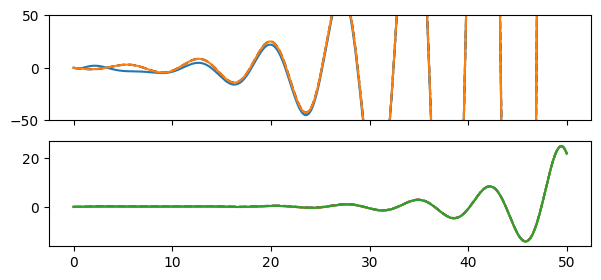

In [31]:
n_steps = len(t)
z = np.zeros((n_steps, r), dtype=complex)  # Kalman filter estimate
y_hat = np.zeros((n_steps, p))  # Kalman filter output

z[0] = x[0]
for i in range(1, n_steps):
    y_hat[i] = np.real(C_kf @ z[i-1] + D_kf * u[i-1])
    z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])


x_rom = np.zeros_like(x)
x_rom[0] = x[0]

for i in range(1, n_steps):
    x_rom[i] = A_kf @ x_rom[i-1] + B_kf @ u[i-1]


fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.real(x[:, 0]), 'k--')
ax[0].plot(t, np.real(z[:, 0]))
ax[0].plot(t, np.real(x_rom[:, 0]))
ax[0].set_ylim([-50, 50])
ax[1].plot(t, y, 'k--')
ax[1].plot(t, x @ C_kf.T + D_kf * u)
ax[1].plot(t, x_rom @ C_kf.T + D_kf * u)
ax[1].plot(t, y_hat)
# ax[2].plot(t, x @ K.T, 'k--')
# ax[2].plot(t, z @ K.T)
# ax[2].set_ylim([-5, 5])
plt.show()

In [21]:
xc[:, 0]

array([1.01812182e+00-9.70669826e-11j, 1.01809558e+00+3.64734950e-03j,
       1.01803241e+00+8.51501919e-03j, ...,
       1.02561090e+03-5.74906064e+02j, 1.03211141e+03-5.66854254e+02j,
       1.03855162e+03-5.58734149e+02j])